Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8764 - root_mean_squared_error: 1.9349 - val_loss: 2.9967 - val_root_mean_squared_error: 1.7311
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6631 - root_mean_squared_error: 0.8115 - val_loss: 1.2068 - val_root_mean_squared_error: 1.0986
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4356 - root_mean_squared_error: 0.6590 - val_loss: 0.3868 - val_root_mean_squared_error: 0.6220
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3494 - root_mean_squared_error: 0.5909 - val_loss: 0.1950 - val_root_mean_squared_error: 0.4416
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3172 - root_mean_squared_error: 0.5628 - val_loss: 0.0893 - val_root_mean_squared_error: 0.2989
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2798 - root_mean_squared_error: 0.5288 - val_loss: 0.0710 - val_root_mean_squared_error: 0.2665
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2400 - ro

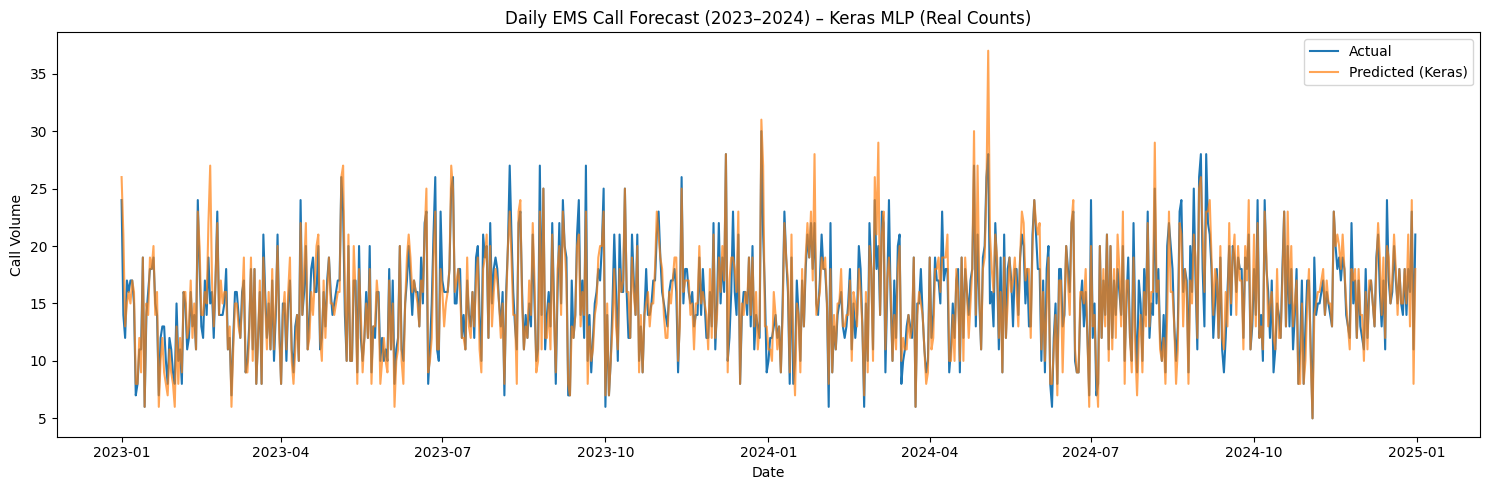


First 10 day predictions:


AttributeError: 'numpy.datetime64' object has no attribute 'date'

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 4. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop missing values ---
daily.dropna(inplace=True)

# --- 6. Define Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 7. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]
y_train = train['call_volume']
y_test = test['call_volume']

# --- 8. Scale Inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 9. Log-transform targets for training ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- 10. Build Keras MLP Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- 11. Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 12. Predict and convert back to real call counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

# --- 13. Evaluate ---
rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Keras MLP RMSE (actual calls): {rmse:.2f}")

# --- 14. Plot (REAL call volumes only — no logs!) ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'].values, y_test_actual.values, label='Actual')
plt.plot(test['date'].values, preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Keras MLP (Real Counts)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

# --- 15. Optional: Print sample predictions ---
print("\nFirst 10 day predictions:")
for d, actual, pred in zip(test['date'].values[:10], y_test_actual[:10], preds[:10]):
    print(f"{d.date()}: Actual = {actual}, Predicted = {pred}")


Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5079 - root_mean_squared_error: 2.3276 - val_loss: 1.0711 - val_root_mean_squared_error: 1.0349
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5984 - root_mean_squared_error: 0.7730 - val_loss: 0.3336 - val_root_mean_squared_error: 0.5776
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3438 - root_mean_squared_error: 0.5862 - val_loss: 0.1865 - val_root_mean_squared_error: 0.4319
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2642 - root_mean_squared_error: 0.5137 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3528
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1965 - root_mean_squared_error: 0.4431 - val_loss: 0.0955 - val_root_mean_squared_error: 0.3091
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1591 - root_mean_squared_error: 0.3988 - val_loss: 0.0694 - val_root_mean_squared_error: 0.2634
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1268 - ro

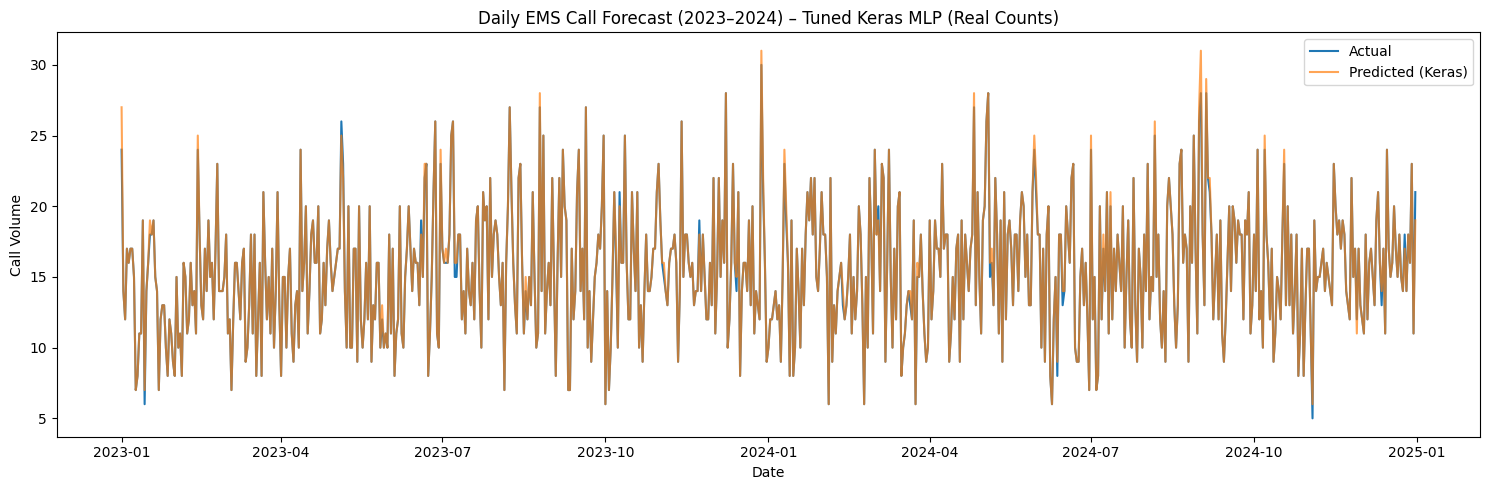

In [2]:
# --- Same preprocessing as before up to Step 8 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Tighter Keras MLP ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Predict in log space, convert to real counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Tuned Keras MLP RMSE (actual calls): {rmse:.2f}")

# --- Plot (real values only) ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'].values, y_test_actual.values, label='Actual')
plt.plot(test['date'].values, preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Tuned Keras MLP (Real Counts)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

In [4]:
preds

array([27, 14, 12, 17, 16, 17, 17, 15,  7,  8, 11, 11, 19,  7, 14, 16, 19,
       18, 19, 15, 14,  7, 12, 13, 13, 10,  8, 12, 11,  9,  8, 15, 10, 11,
        8, 16, 15, 11, 12, 16, 13, 14, 11, 25, 18, 13, 12, 17, 14, 19, 15,
       16, 12, 17, 23, 14, 14, 14, 15, 18, 11, 12,  7, 12, 16, 16, 14, 12,
       16, 17,  9, 10, 13, 18, 11, 18,  8, 12, 16,  8, 21, 16, 12, 15, 11,
       17, 10, 14, 21, 13,  8, 15, 15, 10, 15, 17, 11,  9, 13, 14, 10, 24,
       14, 16, 20, 11, 14, 18, 19, 16, 16, 20, 11, 12, 16, 13, 17, 19, 16,
       14, 15, 16, 17, 17, 25, 22, 14, 10, 20, 10, 10, 17, 17,  9, 20, 12,
       10, 12, 16, 12, 20,  9, 13, 12, 16, 16, 10, 13, 10, 11, 10, 18, 11,
       17,  8, 11, 12, 20, 11, 10, 15, 17, 20, 17, 14, 17, 16, 16, 13, 18,
       15, 23, 23,  8, 11, 15, 21, 26, 11, 10, 24, 17, 16, 17, 16, 18, 25,
       26, 16, 16, 18, 18, 12, 14, 11, 17, 14, 13, 16, 12, 19, 20, 14, 10,
       21, 19, 20, 12, 22, 15, 18, 19, 18, 15, 13, 16,  7, 16, 20, 27, 21,
       16, 13, 11, 22, 23

In [5]:
y_test_actual

2191    24
2192    14
2193    12
2194    17
2195    16
        ..
2917    18
2918    16
2919    23
2920    11
2921    21
Name: call_volume, Length: 731, dtype: int64